## Обработка графиков ЭКГ и преобразование в таблицу

In [531]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder

In [491]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [492]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [493]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-2])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 10.1 s
Wall time: 10.2 s


In [501]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'ecg_id'})

In [502]:
ECG_data = ECG_data.sort_values(by=['ecg_id'], ascending=True)

In [503]:
ECG_data

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


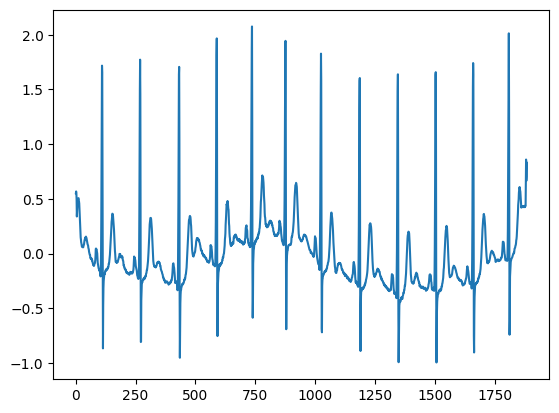

In [504]:
plt.plot(ECG_data.loc[0, 1:]) # график экг после обработки сигнала

## N-граммы

In [71]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [72]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [73]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [74]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [75]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [76]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [77]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [78]:
ECG_data_array = np.array(ECG_data)

In [79]:
R_Peaks = []

In [80]:
ecg_ids = []
encoding_ecgs = []

In [81]:
for ecgsignal in ECG_data_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids.append(ecg_id)
    encoding_ecgs.append(encoding_ecg)

In [82]:
encoding_ecg = pd.Series(encoding_ecgs, index=ecg_ids)

In [83]:
gts = pd.read_csv('train/train_gts.csv')  # данные из файла train_gts.csv
gts.record_name = gts.record_name.map(lambda x: float(x[:-3]))
gts = gts.sort_values(by='record_name')
gts.insert(2, 'encoding_ecg', array(encoding_ecg))
gts

,record_name,myocard,encoding_ecg
265,9.0,0,DDCADDCC
1407,34.0,0,DDDCCCFFFDDFCCCACFE
1833,43.0,0,BFABCFADDEC
441,52.0,0,DDEFBCCBCCF
1834,57.0,0,DDCADBCDD
...,...,...,...
1753,21784.0,0,DDCCFFAFAFFAFC
2008,21795.0,0,
72,21825.0,0,ECCDDDECB
2100,21831.0,0,DAFCCDDDCFCD


In [515]:
array(gts)

array([[9.0, 0, 'DDCADDCC'],
       [34.0, 0, 'DDDCCCFFFDDFCCCACFE'],
       [43.0, 0, 'BFABCFADDEC'],
       ...,
       [21825.0, 0, 'ECCDDDECB'],
       [21831.0, 0, 'DAFCCDDDCFCD'],
       [21834.0, 1, 'CDFCCDAFF']], dtype=object)

In [84]:
sick = gts[gts.myocard == 1].encoding_ecg  # закодированные кардиограммы больных
healthy = gts[gts.myocard == 0].encoding_ecg  # закодированные кардиограммы здоровых

In [85]:
sp_sick= []  # список N-грамм больных
for i in sick:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_sick.append(k)

In [86]:
sp_healthy = []  # список N-грамм здоровых
for i in healthy:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_healthy.append(k)

In [87]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [88]:
q_sick = counter_and_sort(sp_sick) # отсортированные н-граммы больных
q_health = counter_and_sort(sp_healthy)  # отсортированные н-граммы здоровых

In [89]:
only_sick = list(set(q_sick.index) - set(q_health.index)) # н-граммы, встречающиеся только у больных
only_health = list(set(q_health.index) - set(q_sick.index)) # н-граммы, встречающиеся только у здоровых

In [90]:
popular_sick = q_sick.iloc[:len(q_sick) // 2] # н-граммы, чаще всего встречающиеся у больных
popular_health = q_health.iloc[:len(q_health) // 2] # н-граммы, чаще всего встречающиеся у здоровых

In [91]:
# н-граммы, которые чаще всего встречаются у больных и не встречаются у здоровых
popular_sick_only = list(set(popular_sick.index) - set(popular_health.index))

# н-граммы, которые чаще всего встречаются у здоровых и не встречаются у больных
popular_health_only = list(set(popular_health.index) - set(popular_sick.index))

In [92]:
ngramms_ecgs = []  # список н-грамм в кардиограммах
for ecg in array(gts):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[2]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs.append(list(ngramms_ecg))

In [93]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    ng_health = sum(list(map(lambda x: 1 if x in only_health else 0, ng)))
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))

    ng_popular_health = sum(list(map(lambda x: 1 if x in popular_health_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))

    return [ng_health, ng_sick, ng_popular_health, ng_popular_sick]

In [94]:
arr = pd.DataFrame([func(ng) for ng in ngramms_ecgs])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(arr, gts.myocard, random_state=0, test_size=0.75)
# разбиение на тестовый и тренировочный датасет

In [96]:
cat_n_gramms = CatBoostClassifier(depth=9,  learning_rate=0.03)
cat_n_gramms.fit(X_train, y_train)

0:	learn: 0.6444023	total: 5.7ms	remaining: 5.7s
1:	learn: 0.6138423	total: 9.6ms	remaining: 4.79s
2:	learn: 0.5774073	total: 15.3ms	remaining: 5.09s
3:	learn: 0.5306864	total: 18.8ms	remaining: 4.69s
4:	learn: 0.4964606	total: 25.4ms	remaining: 5.06s
5:	learn: 0.4700599	total: 30.2ms	remaining: 5.01s
6:	learn: 0.4540542	total: 33ms	remaining: 4.68s
7:	learn: 0.4295647	total: 36.9ms	remaining: 4.57s
8:	learn: 0.4147643	total: 41ms	remaining: 4.51s
9:	learn: 0.3949265	total: 46.6ms	remaining: 4.61s
10:	learn: 0.3697582	total: 49.9ms	remaining: 4.49s
11:	learn: 0.3527951	total: 56.6ms	remaining: 4.66s
12:	learn: 0.3357232	total: 62ms	remaining: 4.71s
13:	learn: 0.3178687	total: 68.6ms	remaining: 4.83s
14:	learn: 0.3044209	total: 75.1ms	remaining: 4.93s
15:	learn: 0.2972470	total: 81.8ms	remaining: 5.03s
16:	learn: 0.2931901	total: 85.6ms	remaining: 4.95s
17:	learn: 0.2835730	total: 90.3ms	remaining: 4.93s
18:	learn: 0.2761427	total: 95.5ms	remaining: 4.93s
19:	learn: 0.2699636	total: 102

192:	learn: 0.1654006	total: 813ms	remaining: 3.4s
193:	learn: 0.1653423	total: 819ms	remaining: 3.4s
194:	learn: 0.1653380	total: 823ms	remaining: 3.4s
195:	learn: 0.1653301	total: 829ms	remaining: 3.4s
196:	learn: 0.1653076	total: 835ms	remaining: 3.4s
197:	learn: 0.1652475	total: 840ms	remaining: 3.4s
198:	learn: 0.1652389	total: 845ms	remaining: 3.4s
199:	learn: 0.1652362	total: 848ms	remaining: 3.39s
200:	learn: 0.1651855	total: 861ms	remaining: 3.42s
201:	learn: 0.1651755	total: 867ms	remaining: 3.42s
202:	learn: 0.1651116	total: 873ms	remaining: 3.43s
203:	learn: 0.1651068	total: 880ms	remaining: 3.43s
204:	learn: 0.1650917	total: 884ms	remaining: 3.43s
205:	learn: 0.1650161	total: 889ms	remaining: 3.43s
206:	learn: 0.1649998	total: 891ms	remaining: 3.41s
207:	learn: 0.1649927	total: 894ms	remaining: 3.4s
208:	learn: 0.1649764	total: 899ms	remaining: 3.4s
209:	learn: 0.1649487	total: 904ms	remaining: 3.4s
210:	learn: 0.1649435	total: 907ms	remaining: 3.39s
211:	learn: 0.1649267	

374:	learn: 0.1609192	total: 1.63s	remaining: 2.72s
375:	learn: 0.1609101	total: 1.64s	remaining: 2.71s
376:	learn: 0.1609026	total: 1.64s	remaining: 2.71s
377:	learn: 0.1608940	total: 1.64s	remaining: 2.71s
378:	learn: 0.1608849	total: 1.65s	remaining: 2.7s
379:	learn: 0.1608782	total: 1.65s	remaining: 2.7s
380:	learn: 0.1608696	total: 1.66s	remaining: 2.69s
381:	learn: 0.1608614	total: 1.66s	remaining: 2.69s
382:	learn: 0.1608542	total: 1.67s	remaining: 2.69s
383:	learn: 0.1608454	total: 1.67s	remaining: 2.68s
384:	learn: 0.1608375	total: 1.68s	remaining: 2.68s
385:	learn: 0.1608301	total: 1.68s	remaining: 2.67s
386:	learn: 0.1608237	total: 1.69s	remaining: 2.67s
387:	learn: 0.1608160	total: 1.69s	remaining: 2.67s
388:	learn: 0.1608075	total: 1.7s	remaining: 2.67s
389:	learn: 0.1607996	total: 1.7s	remaining: 2.66s
390:	learn: 0.1607934	total: 1.71s	remaining: 2.66s
391:	learn: 0.1607856	total: 1.71s	remaining: 2.65s
392:	learn: 0.1607783	total: 1.71s	remaining: 2.65s
393:	learn: 0.16

548:	learn: 0.1601529	total: 2.44s	remaining: 2s
549:	learn: 0.1601506	total: 2.44s	remaining: 2s
550:	learn: 0.1601484	total: 2.45s	remaining: 1.99s
551:	learn: 0.1601463	total: 2.45s	remaining: 1.99s
552:	learn: 0.1601438	total: 2.46s	remaining: 1.99s
553:	learn: 0.1601415	total: 2.46s	remaining: 1.98s
554:	learn: 0.1601394	total: 2.47s	remaining: 1.98s
555:	learn: 0.1601368	total: 2.47s	remaining: 1.97s
556:	learn: 0.1601345	total: 2.48s	remaining: 1.97s
557:	learn: 0.1601323	total: 2.48s	remaining: 1.96s
558:	learn: 0.1601301	total: 2.48s	remaining: 1.96s
559:	learn: 0.1601281	total: 2.49s	remaining: 1.96s
560:	learn: 0.1601259	total: 2.5s	remaining: 1.95s
561:	learn: 0.1601239	total: 2.5s	remaining: 1.95s
562:	learn: 0.1601218	total: 2.5s	remaining: 1.94s
563:	learn: 0.1601195	total: 2.51s	remaining: 1.94s
564:	learn: 0.1601174	total: 2.51s	remaining: 1.94s
565:	learn: 0.1601152	total: 2.52s	remaining: 1.93s
566:	learn: 0.1601132	total: 2.52s	remaining: 1.93s
567:	learn: 0.1601110

723:	learn: 0.1598761	total: 3.24s	remaining: 1.24s
724:	learn: 0.1598751	total: 3.25s	remaining: 1.23s
725:	learn: 0.1598740	total: 3.25s	remaining: 1.23s
726:	learn: 0.1598729	total: 3.26s	remaining: 1.22s
727:	learn: 0.1598718	total: 3.26s	remaining: 1.22s
728:	learn: 0.1598708	total: 3.27s	remaining: 1.21s
729:	learn: 0.1598699	total: 3.27s	remaining: 1.21s
730:	learn: 0.1598687	total: 3.28s	remaining: 1.21s
731:	learn: 0.1598674	total: 3.28s	remaining: 1.2s
732:	learn: 0.1598665	total: 3.29s	remaining: 1.2s
733:	learn: 0.1598653	total: 3.29s	remaining: 1.19s
734:	learn: 0.1598643	total: 3.29s	remaining: 1.19s
735:	learn: 0.1598630	total: 3.3s	remaining: 1.18s
736:	learn: 0.1598619	total: 3.3s	remaining: 1.18s
737:	learn: 0.1598607	total: 3.31s	remaining: 1.17s
738:	learn: 0.1598596	total: 3.31s	remaining: 1.17s
739:	learn: 0.1598587	total: 3.32s	remaining: 1.17s
740:	learn: 0.1598575	total: 3.32s	remaining: 1.16s
741:	learn: 0.1598565	total: 3.33s	remaining: 1.16s
742:	learn: 0.15

900:	learn: 0.1597255	total: 4.04s	remaining: 444ms
901:	learn: 0.1597250	total: 4.05s	remaining: 440ms
902:	learn: 0.1597242	total: 4.05s	remaining: 435ms
903:	learn: 0.1597237	total: 4.06s	remaining: 431ms
904:	learn: 0.1597230	total: 4.06s	remaining: 426ms
905:	learn: 0.1597224	total: 4.07s	remaining: 422ms
906:	learn: 0.1597218	total: 4.07s	remaining: 418ms
907:	learn: 0.1597212	total: 4.08s	remaining: 413ms
908:	learn: 0.1597205	total: 4.09s	remaining: 410ms
909:	learn: 0.1597200	total: 4.1s	remaining: 405ms
910:	learn: 0.1597195	total: 4.1s	remaining: 401ms
911:	learn: 0.1597187	total: 4.11s	remaining: 397ms
912:	learn: 0.1597181	total: 4.11s	remaining: 392ms
913:	learn: 0.1597175	total: 4.12s	remaining: 388ms
914:	learn: 0.1597166	total: 4.13s	remaining: 383ms
915:	learn: 0.1597158	total: 4.13s	remaining: 379ms
916:	learn: 0.1597152	total: 4.14s	remaining: 375ms
917:	learn: 0.1597147	total: 4.14s	remaining: 370ms
918:	learn: 0.1597141	total: 4.15s	remaining: 366ms
919:	learn: 0.

In [97]:
f1_score(y_test, cat_n_gramms.predict(X_test), average='macro')

0.8612836391384646

In [98]:
f1_score(y_train, cat_n_gramms.predict(X_train), average='macro')

0.8722361284939507

## Анализ HRV сигнала

In [99]:
hrv_data = pd.DataFrame(columns=['M', 'sco', 'coefficient_cov', 'amplitude', 'y'])
#создание датафрейма со статистическими показателями сигнала

In [100]:
hrv_data.y = gts.myocard

In [101]:
RR = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks))

In [102]:
M = list(map(lambda rr: rr.mean(), RR)) #подсчёт математического ожидания

In [103]:
hrv_data.M = M

(array([321.,  37.,  12.,  14.,   7.,  12.,   1.,   5.,   5.,   1.]),
 array([2.53173721e-01, 3.63636616e+05, 7.27272979e+05, 1.09090934e+06,
        1.45454570e+06, 1.81818207e+06, 2.18181843e+06, 2.54545479e+06,
        2.90909115e+06, 3.27272752e+06, 3.63636388e+06]),
 <BarContainer object of 10 artists>)

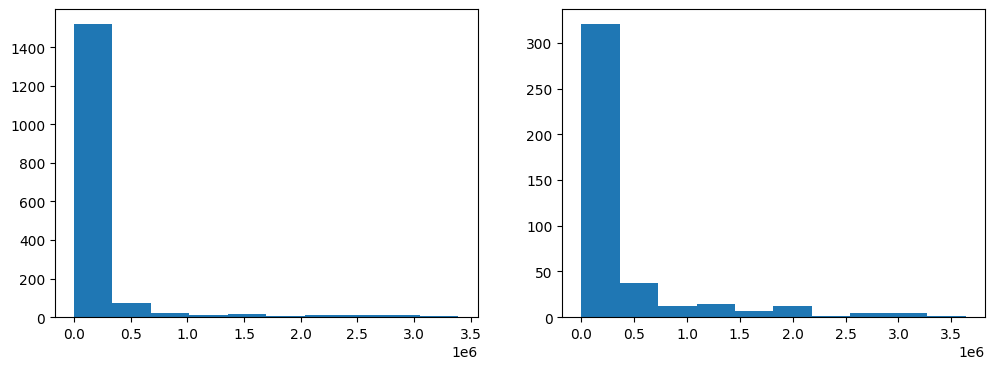

In [104]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #построение графиков для сравнения математического ожидания у больных

axes[0].hist(hrv_data.M[hrv_data.y == 0])
axes[1].hist(hrv_data.M[hrv_data.y == 1])
#как видно, особых различий в распределении у больных и здоровых нет

In [105]:
def analysis_mat_expectation(M): #кодирование математического ожидания
    if M < 0.5:
        return 0
    elif 0.5 <= M < 0.66:
        return 1
    elif 0.66 <= M:
        return 2

In [106]:
hrv_data.M = list(map(lambda m: analysis_mat_expectation(m), M))

In [107]:
def moda_and_amplitude(peaks): #функция подсчёта моды и амплитуды
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if fabs(f[t + 1] - f[m]) / 100 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m

    def amplitude_mode():
        return 100 * count_mode[max] / len(peaks)

    return amplitude_mode()

In [108]:
def analysis_amplitude(amplitude): #кодирование амплитуды

    if 65 <= amplitude < 100:
        return 0
    else:
        return 1

In [109]:
amplitude = list(map(lambda rpeaks: moda_and_amplitude(rpeaks), R_Peaks))

In [110]:
hrv_data.amplitude = amplitude

(array([25., 73., 70., 76., 61., 35., 32., 13., 16., 14.]),
 array([ 7.14285714, 15.37593985, 23.60902256, 31.84210526, 40.07518797,
        48.30827068, 56.54135338, 64.77443609, 73.0075188 , 81.2406015 ,
        89.47368421]),
 <BarContainer object of 10 artists>)

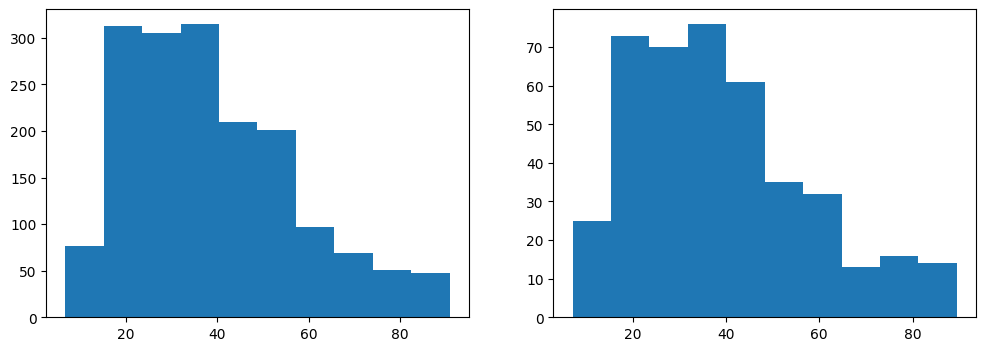

In [111]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.amplitude[hrv_data.y == 0])
axes[1].hist(hrv_data.amplitude[hrv_data.y == 1])
#распределение у обеих групп совпадает и особых различий нет

In [112]:
hrv_data.amplitude = list(map(lambda a: analysis_amplitude(a), amplitude))

In [113]:
def SCO(array, index): #функция для подсчёта среднего квадратичного отклонения
  global ECG_data_array
  R_values = [ECG_data_array[index][j] for j in array]
  n = len(R_values)
  mean = np.array(R_values).mean()
  summ = sum([(i - mean) ** 2 for i in R_values])
  return (summ / (n - 1)) ** 0.5

In [119]:
sco_values = [SCO(R_Peaks[i], i) for i in range(len(R_Peaks))]
hrv_data.sco = sco_values

(array([413.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.76030475e-02, 1.98928259e+02, 3.97838915e+02, 5.96749571e+02,
        7.95660226e+02, 9.94570882e+02, 1.19348154e+03, 1.39239219e+03,
        1.59130285e+03, 1.79021351e+03, 1.98912416e+03]),
 <BarContainer object of 10 artists>)

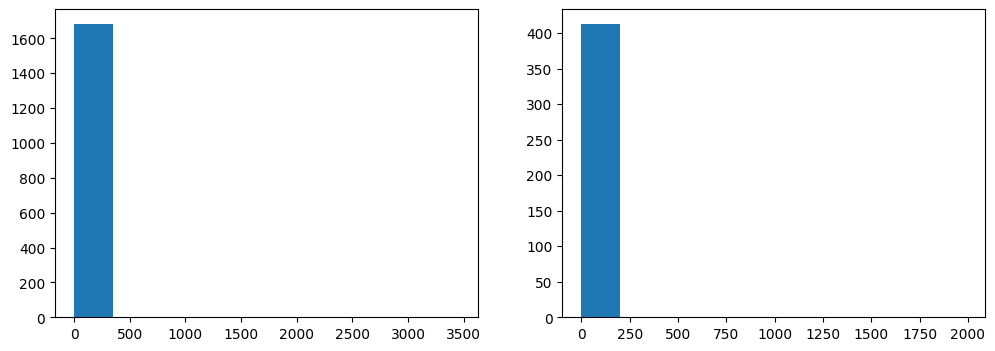

In [115]:
fig, axes = plt.subplots(1, 2, figsize = (12,4)) #графики для сравнения амплитуды у больных и здоровых

axes[0].hist(hrv_data.sco[hrv_data.y == 0])
axes[1].hist(hrv_data.sco[hrv_data.y == 1])
#графики схожи и их них нельзя получить достаточно информации о различии sco у больных и здоровых

In [120]:
def coefficient_covariance(M, SCO):
    return 100 * array(SCO) / array(M)

In [121]:
coefficient_covariance = coefficient_covariance(M, sco_values)

In [122]:
hrv_data.coefficient_cov = coefficient_covariance

In [123]:
hrv_data

,M,sco,coefficient_cov,amplitude,y
265,0,0.285955,88.015834,1,0
1407,2,0.224696,31.806020,0,0
1833,0,0.182978,43.126229,1,0
441,0,0.234888,56.993168,1,0
1834,0,0.295042,84.761525,1,0
...,...,...,...,...,...
1753,1,0.190881,37.008425,0,0
2008,0,0.241930,67.041060,1,0
72,0,0.166227,46.153706,1,0
2100,0,0.087173,19.102480,1,0


## Анализ метаданных

In [532]:
df = pd.read_csv('train/train_meta.csv')

In [533]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
4,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3


In [534]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        2101 non-null   int64  
 1   patient_id                    2101 non-null   float64
 2   age                           2101 non-null   float64
 3   sex                           2101 non-null   int64  
 4   height                        689 non-null    float64
 5   weight                        905 non-null    float64
 6   nurse                         1947 non-null   float64
 7   site                          2100 non-null   float64
 8   device                        2101 non-null   object 
 9   recording_date                2101 non-null   object 
 10  report                        2101 non-null   object 
 11  scp_codes                     2101 non-null   object 
 12  heart_axis                    1231 non-null   object 
 13  inf

In [535]:
myocard_list = list(gts['myocard'])
df.insert(loc=len(df.columns), column='myocard', value=myocard_list)

In [536]:
d1 = list(df['static_noise'])
d2 = list(df['burst_noise'])
d3 = list(df['electrodes_problems'])
d4 = list(df['baseline_drift'])

In [538]:
df[['weight', 'height']] = df[['weight', 'height']].fillna(df[['weight', 'height']].mean())

combo_info = df['weight'].astype(str) + '_' + df['height'].astype(str) + '_' + df['age'].astype(str) \
    + '_' + df['sex'].astype(str)
df.insert(0, 'combo_info', combo_info)

In [ ]:
#df['combo_info'] = df.groupby('combo_info')['myocard'].transform('mean')
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [539]:
target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df.combo_info, df.myocard)
target_encoded_combo_info = target_encoder_combo_info.transform(df.combo_info)
df.combo_info = target_encoded_combo_info.astype('category')

In [540]:
df.combo_info

0       0.171825
1       0.193825
2       0.171825
3       0.171825
4       0.171825
          ...   
2096    0.234080
2097    0.233652
2098    0.238874
2099    0.198459
2100    0.307432
Name: combo_info, Length: 2101, dtype: category
Categories (64, float64): [0.118827, 0.140430, 0.144402, 0.152844, ..., 0.304705, 0.307432, 0.313729, 0.333632]

In [160]:
df['scp_codes'] = df.groupby('scp_codes')['myocard'].transform('mean') #стандарт для обмена цифровыми ЭКГ

df['infarction_stadium1'] = df.groupby('infarction_stadium1')['myocard'].transform('mean') #стадия инфаркта
df['infarction_stadium2'] = df.groupby('infarction_stadium2')['myocard'].transform('mean') #вторая стадия инфаркта
df[['infarction_stadium1', 'infarction_stadium2']] = df[['infarction_stadium1', 'infarction_stadium2']].fillna(0)
#заполнение пустых значений нулём

df['heart_axis'] = df.groupby('heart_axis')['myocard'].transform('mean') #электрическая ось сердца
oft_value1 = df['heart_axis'].value_counts().idxmax()
df['heart_axis'] = df['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением

df['device'] = df.groupby('device')['myocard'].transform('mean') #устройство записи
df['report'] = df.groupby('report')['myocard'].transform('mean') #краткий доклад о экг пациента

df['extra_beats'] = df.groupby('extra_beats')['myocard'].transform('mean')
#дополнительные удары сердца(обычно никак не влияют на здоров/болен)
df['extra_beats'] = df['extra_beats'].fillna(0)

oft_value2 = df['nurse'].value_counts().idxmax() #"номер" медсестры
df['nurse'] = df['nurse'].fillna(oft_value2)

oft_value3 = df['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df['validated_by'] = df['validated_by'].fillna(oft_value3)

df['pacemaker'] = df.groupby('pacemaker')['myocard'].transform('mean')
#кардиостимулятор(регулирует функцию электрической проводящей системы сердца)
df['pacemaker'] = df['pacemaker'].fillna(0)

oft_value4 = df['site'].value_counts().idxmax() #"номер" сайта записи
df['site'] = df['site'].fillna(oft_value4)

In [161]:
df.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight', 'static_noise',
         'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [162]:
df.head()

,combo_info,ecg_id,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group,myocard
0,0.000000,9,18792.0,2.0,0.0,0.035294,0.0,0.021776,0.107735,0.0,0.0,0.0,False,False,True,0.0,0.0,10,1,0
1,0.190476,34,13619.0,2.0,0.0,0.035294,0.0,0.000000,0.107735,0.0,0.0,1.0,False,False,True,0.0,0.0,9,3,0
2,0.000000,43,11315.0,2.0,0.0,0.035294,0.0,0.021776,0.107735,0.0,0.0,0.0,False,False,True,0.0,0.0,8,3,0
3,0.000000,52,18153.0,2.0,0.0,0.035294,0.0,0.086957,0.107735,0.0,0.0,0.0,False,False,True,0.0,0.0,1,2,0
4,0.000000,57,16063.0,2.0,0.0,0.035294,0.0,0.021776,0.107735,0.0,0.0,0.0,False,False,True,0.0,0.0,10,3,0


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    2101 non-null   float64
 1   ecg_id                        2101 non-null   int64  
 2   patient_id                    2101 non-null   float64
 3   nurse                         2101 non-null   float64
 4   site                          2101 non-null   float64
 5   device                        2101 non-null   float64
 6   report                        2101 non-null   float64
 7   scp_codes                     2101 non-null   float64
 8   heart_axis                    2101 non-null   float64
 9   infarction_stadium1           2101 non-null   float64
 10  infarction_stadium2           2101 non-null   float64
 11  validated_by                  2101 non-null   float64
 12  second_opinion                2101 non-null   bool   
 13  ini

In [164]:
df.corr()['myocard']

combo_info                      0.666498
ecg_id                          0.052896
patient_id                      0.007507
nurse                           0.030785
site                           -0.030098
device                          0.181227
report                          0.952537
scp_codes                       0.913851
heart_axis                      0.290625
infarction_stadium1             0.706610
infarction_stadium2             0.106942
validated_by                   -0.011176
second_opinion                 -0.033411
initial_autogenerated_report    0.061033
validated_by_human             -0.088836
extra_beats                     0.084666
pacemaker                      -0.049636
strat_fold                     -0.024464
group                           0.004394
myocard                         1.000000
Name: myocard, dtype: float64

In [165]:
values = df.values
X = values[:,0:18]
y = values[:,19]
y=y.astype('int')

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [167]:
cat_meta = CatBoostClassifier(depth=8,  learning_rate=0.05)
cat_meta.fit(X_train, y_train)

0:	learn: 0.5893081	total: 9.69ms	remaining: 9.68s
1:	learn: 0.5039263	total: 20.3ms	remaining: 10.1s
2:	learn: 0.4279600	total: 28.4ms	remaining: 9.43s
3:	learn: 0.3582772	total: 37.5ms	remaining: 9.34s
4:	learn: 0.3077747	total: 46.2ms	remaining: 9.2s
5:	learn: 0.2612373	total: 55.6ms	remaining: 9.22s
6:	learn: 0.2241976	total: 65ms	remaining: 9.22s
7:	learn: 0.1930321	total: 73.7ms	remaining: 9.14s
8:	learn: 0.1692367	total: 82.5ms	remaining: 9.08s
9:	learn: 0.1465743	total: 92.1ms	remaining: 9.12s
10:	learn: 0.1294500	total: 101ms	remaining: 9.05s
11:	learn: 0.1150329	total: 109ms	remaining: 8.98s
12:	learn: 0.1004164	total: 118ms	remaining: 8.96s
13:	learn: 0.0908401	total: 126ms	remaining: 8.88s
14:	learn: 0.0791109	total: 134ms	remaining: 8.78s
15:	learn: 0.0710310	total: 139ms	remaining: 8.54s
16:	learn: 0.0645855	total: 146ms	remaining: 8.46s
17:	learn: 0.0598393	total: 155ms	remaining: 8.46s
18:	learn: 0.0546675	total: 164ms	remaining: 8.44s
19:	learn: 0.0515511	total: 171ms	

172:	learn: 0.0019237	total: 1.47s	remaining: 7.04s
173:	learn: 0.0019085	total: 1.48s	remaining: 7.03s
174:	learn: 0.0018976	total: 1.49s	remaining: 7.02s
175:	learn: 0.0018802	total: 1.5s	remaining: 7.01s
176:	learn: 0.0018660	total: 1.5s	remaining: 7s
177:	learn: 0.0018458	total: 1.51s	remaining: 6.98s
178:	learn: 0.0018292	total: 1.52s	remaining: 6.97s
179:	learn: 0.0018184	total: 1.53s	remaining: 6.96s
180:	learn: 0.0018066	total: 1.53s	remaining: 6.95s
181:	learn: 0.0017885	total: 1.54s	remaining: 6.94s
182:	learn: 0.0017705	total: 1.55s	remaining: 6.92s
183:	learn: 0.0017556	total: 1.56s	remaining: 6.92s
184:	learn: 0.0017447	total: 1.57s	remaining: 6.91s
185:	learn: 0.0017332	total: 1.57s	remaining: 6.89s
186:	learn: 0.0017156	total: 1.58s	remaining: 6.88s
187:	learn: 0.0016986	total: 1.59s	remaining: 6.87s
188:	learn: 0.0016875	total: 1.6s	remaining: 6.85s
189:	learn: 0.0016778	total: 1.6s	remaining: 6.84s
190:	learn: 0.0016638	total: 1.61s	remaining: 6.83s
191:	learn: 0.00164

354:	learn: 0.0008033	total: 2.92s	remaining: 5.3s
355:	learn: 0.0008018	total: 2.92s	remaining: 5.29s
356:	learn: 0.0007966	total: 2.93s	remaining: 5.28s
357:	learn: 0.0007915	total: 2.94s	remaining: 5.28s
358:	learn: 0.0007865	total: 2.95s	remaining: 5.27s
359:	learn: 0.0007817	total: 2.96s	remaining: 5.26s
360:	learn: 0.0007802	total: 2.96s	remaining: 5.25s
361:	learn: 0.0007791	total: 2.97s	remaining: 5.24s
362:	learn: 0.0007743	total: 2.98s	remaining: 5.23s
363:	learn: 0.0007729	total: 2.99s	remaining: 5.22s
364:	learn: 0.0007682	total: 3.01s	remaining: 5.24s
365:	learn: 0.0007636	total: 3.02s	remaining: 5.23s
366:	learn: 0.0007592	total: 3.03s	remaining: 5.22s
367:	learn: 0.0007578	total: 3.04s	remaining: 5.21s
368:	learn: 0.0007534	total: 3.05s	remaining: 5.21s
369:	learn: 0.0007520	total: 3.05s	remaining: 5.2s
370:	learn: 0.0007506	total: 3.06s	remaining: 5.2s
371:	learn: 0.0007462	total: 3.08s	remaining: 5.19s
372:	learn: 0.0007419	total: 3.09s	remaining: 5.19s
373:	learn: 0.0

532:	learn: 0.0006759	total: 4.3s	remaining: 3.77s
533:	learn: 0.0006759	total: 4.31s	remaining: 3.76s
534:	learn: 0.0006759	total: 4.31s	remaining: 3.75s
535:	learn: 0.0006759	total: 4.32s	remaining: 3.74s
536:	learn: 0.0006759	total: 4.33s	remaining: 3.73s
537:	learn: 0.0006759	total: 4.33s	remaining: 3.72s
538:	learn: 0.0006759	total: 4.34s	remaining: 3.71s
539:	learn: 0.0006759	total: 4.34s	remaining: 3.7s
540:	learn: 0.0006759	total: 4.35s	remaining: 3.69s
541:	learn: 0.0006759	total: 4.36s	remaining: 3.68s
542:	learn: 0.0006759	total: 4.37s	remaining: 3.68s
543:	learn: 0.0006759	total: 4.37s	remaining: 3.67s
544:	learn: 0.0006759	total: 4.38s	remaining: 3.66s
545:	learn: 0.0006759	total: 4.4s	remaining: 3.66s
546:	learn: 0.0006759	total: 4.41s	remaining: 3.65s
547:	learn: 0.0006759	total: 4.42s	remaining: 3.65s
548:	learn: 0.0006759	total: 4.43s	remaining: 3.64s
549:	learn: 0.0006759	total: 4.44s	remaining: 3.63s
550:	learn: 0.0006759	total: 4.45s	remaining: 3.63s
551:	learn: 0.0

708:	learn: 0.0006759	total: 5.7s	remaining: 2.34s
709:	learn: 0.0006759	total: 5.71s	remaining: 2.33s
710:	learn: 0.0006759	total: 5.71s	remaining: 2.32s
711:	learn: 0.0006759	total: 5.72s	remaining: 2.31s
712:	learn: 0.0006759	total: 5.73s	remaining: 2.31s
713:	learn: 0.0006759	total: 5.74s	remaining: 2.3s
714:	learn: 0.0006759	total: 5.75s	remaining: 2.29s
715:	learn: 0.0006759	total: 5.76s	remaining: 2.28s
716:	learn: 0.0006759	total: 5.77s	remaining: 2.27s
717:	learn: 0.0006759	total: 5.77s	remaining: 2.27s
718:	learn: 0.0006759	total: 5.78s	remaining: 2.26s
719:	learn: 0.0006759	total: 5.79s	remaining: 2.25s
720:	learn: 0.0006759	total: 5.8s	remaining: 2.24s
721:	learn: 0.0006759	total: 5.81s	remaining: 2.23s
722:	learn: 0.0006759	total: 5.81s	remaining: 2.23s
723:	learn: 0.0006759	total: 5.82s	remaining: 2.22s
724:	learn: 0.0006759	total: 5.83s	remaining: 2.21s
725:	learn: 0.0006759	total: 5.83s	remaining: 2.2s
726:	learn: 0.0006759	total: 5.84s	remaining: 2.19s
727:	learn: 0.00

883:	learn: 0.0006759	total: 7.14s	remaining: 937ms
884:	learn: 0.0006759	total: 7.15s	remaining: 929ms
885:	learn: 0.0006759	total: 7.16s	remaining: 921ms
886:	learn: 0.0006759	total: 7.16s	remaining: 913ms
887:	learn: 0.0006759	total: 7.17s	remaining: 904ms
888:	learn: 0.0006759	total: 7.18s	remaining: 896ms
889:	learn: 0.0006759	total: 7.19s	remaining: 888ms
890:	learn: 0.0006759	total: 7.19s	remaining: 880ms
891:	learn: 0.0006759	total: 7.2s	remaining: 872ms
892:	learn: 0.0006759	total: 7.21s	remaining: 864ms
893:	learn: 0.0006759	total: 7.21s	remaining: 856ms
894:	learn: 0.0006759	total: 7.22s	remaining: 847ms
895:	learn: 0.0006759	total: 7.23s	remaining: 839ms
896:	learn: 0.0006759	total: 7.24s	remaining: 831ms
897:	learn: 0.0006759	total: 7.24s	remaining: 823ms
898:	learn: 0.0006759	total: 7.25s	remaining: 815ms
899:	learn: 0.0006759	total: 7.26s	remaining: 806ms
900:	learn: 0.0006759	total: 7.26s	remaining: 798ms
901:	learn: 0.0006759	total: 7.27s	remaining: 790ms
902:	learn: 0

In [168]:
f1_score(y_train, cat_meta.predict(X_train), average = 'macro')

1.0

In [169]:
f1_score(y_test, cat_meta.predict(X_test), average = 'macro')

0.9925211166378469

# Геометрический анализ

In [383]:
pokaz = []
for ecg_1, ecgsignal in enumerate(ECG_data_array):
  Itg_danny = []
  T_k = [[]]
  try:
    peaks = peakdetect(ecgsignal, lookahead=7, delta=1)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])
    del_ekg = [j-i for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:])]
    itg_del = []
    for min_del_ekg in del_ekg:
      for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:]):
        if j - i == min_del_ekg:
          itg_del.append(list(range(int(i), int(j)))) #поиск точек по которым возможно было бы разделить кардиограмму
    end_del = []
    for ith in sorted(unique(itg_del)): #обработка исключения
      if len(sorted(unique(itg_del))) > 100:
        continue
    for min_itg_del in sorted(unique(itg_del)):
      iop = scipy.signal.find_peaks(ecgsignal[:min_itg_del[0]], distance=30)[0]
      if len(iop) > 2:
        pass
      if min_itg_del[-1] - min_itg_del[0] > 40:
        end_del.append(min_itg_del)
      elif min_itg_del[-1] - min_itg_del[0] < 40:
        if len(end_del) > 1:
          end_del.append(end_del[-1] + min_itg_del) #уточнение и склеивание некоторых, слишком мелких участков
          end_del.pop(-2)
    vh = 0
    end_delk = []
    end_del = sorted(unique(end_del))
  except IndexError:
    continue
  except ValueError:
    continue
  def cycle_teeth(end_del, vh, end_delk, Itg_danny): #основная функция для поиска зубцов
    for k in end_del:
     k1, k2 = np.array_split(k, 2)
     if len(k1) / len(np.array_split(end_del[0], 2)[0]) > 7 and k1[0] + vh != (np.array_split(end_del[0], 2)[0])[0]: #определение допустимости использования участка
       pass
     else:
       slopes = np.diff(ecgsignal[k1]) / np.diff(k1)
       sloup = np.diff(ecgsignal[k2][::-1]) / np.diff(k2[::-1])
       scipy.signal.find_peaks(ecgsignal[k1])
       idxx = np.argmax(slopes < 0.02)
       idx = idxx
       try:
         mean_height = np.argmax(slopes[2:] < 0.02)
         mean_heighty = np.argsort(slopes < 0.02)

         mean_height = [i for i in mean_heighty if i > scipy.signal.find_peaks(ecgsignal[k1])[0][0]][-1] # нахождение дополнительной точки для определения амплитуды
       except IndexError:
         vh += len(k)
         continue
       while ecgsignal[k1][idx] < -0.5 + ecgsignal[k1][idx]:
         slopes = np.diff(ecgsignal[k1][idx + 1:]) / np.diff(k1[idx + 1:])
         idx = np.argmax(slopes < 0.05)
       tchkpT = ecgsignal[k1][idx:]
       peaks = peakdetect(ecgsignal[k1], lookahead=1)
       lowerPeaks = np.array([pek for pek in peaks[1] if pek[0] > idx])[1:]
       if lowerPeaks == [] or len(lowerPeaks) < 2:
         T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
       else:
          if abs(np.max(tchkpT) - ecgsignal[k1][idx]) > abs(np.min([io[1] for io in lowerPeaks]) + ecgsignal[k1][idx]):
            T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
          else:
           T_tk = np.where(ecgsignal[k1] == np.min([io[1] for io in lowerPeaks]))[0] #определение положения зубца T
       flagR_cycle = -2
       oi = False
       try:
         R_tk = scipy.signal.find_peaks(ecgsignal[k2])[0][-1]
       except IndexError:
         vh += len(k)
         continue
       try:
         while ecgsignal[k2][R_tk] not in sorted(ecgsignal[k2], reverse=True)[:5]: #определение положения зубца R
            maxTchk_k2 = (scipy.signal.find_peaks(ecgsignal[k2]))
            R_tk = maxTchk_k2[0][flagR_cycle]
            flagR_cycle -= 1
            if -(flagR_cycle) > 5:
              R_tk = maxTchk_k2[0][-1]
              break
       except IndexError:
         vh += len(k)
         continue
       if min([ecgsignal[k2][R_tk], T_k[-1]]) * 1.5 > max([ecgsignal[k2][R_tk], T_k[-1]]) and T_k[-1] != []: #сравние высот зубцов R и T
         if end_del.index(k) - 1 < len(end_del):
           vh += len(k)
           continue
         vh += len(k)
         continue
       if ecgsignal[k2][R_tk] < ecgsignal[k1][T_tk] and ecgsignal[k][T_tk + 10] < ecgsignal[k2][R_tk]:
         end_delk.append(k[::-1])
       sl = np.array_split(k2, 2)[1]
       spisok_abrabot = []
       ecgsig_1 = ecgsignal[k1]
       spisok_abrabot.append([mean_height, ecgsignal[k1][mean_height]])
       sloup = np.diff(ecgsignal[k1][int(T_tk):]) / np.diff(k1[int(T_tk):])
       idxx = [ps for ps in sloup if ps < 0.02]
       try:
         spisok_abrabot.append([T_tk, ecgsig_1[T_tk]]) #добавление зубца T в список для обработки

         T_k.append(ecgsig_1[T_tk])
       except IndexError:
        vh += len(k)
        continue

       ecgsig_2 = ecgsignal[k2]
       sloup = np.diff(ecgsignal[k2][:int(R_tk)]) / np.diff(k2[:int(R_tk)])
       idxx = [ps for ps in sloup if ps < 0.02]
       spisok_abrabot.append([R_tk, ecgsig_2[R_tk]]) #добавление зубца R в список для обработки
       try:
         pass
       except IndexError:
         vh += len(k)
         continue
       ji = []
       sp_Q = []
       try:
         if len(sl[:R_tk - len(np.array_split(k2, 2)[0])]) < max(scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]):
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])]) #заполнение списка для обработки данными при невыполении условий
           spisok_abrabot.append([k, k1, k2])
           Itg_danny.append([spisok_abrabot])
           vh += len(k)
           continue
       except ValueError:
         pass
       try:
         for koord1, koord2 in zip(ecgsignal[sl][:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(-1 * ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]], sl[:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]]):
           kop = 0
           ji.append(koord1)
           sp_Q.append([koord1, np.where(ecgsignal[k2] == koord1)[0]]) #наполнение списка возможными зубцами для Q
       except IndexError:
         vh += len(k)
         continue
       f = -1
       if len(sp_Q) < 4:
         if sp_Q == []:
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])]) #заполнение списка данными при невыполении условий
            spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
            spisok_abrabot.append([k, k1, k2])
            Itg_danny.append([spisok_abrabot])
            vh += len(k)
            continue

         if len(sp_Q) == 1:                                 #нахождение и добавление в список обработки Q в определенных условиях
          spisok_abrabot.append([sp_Q[0][1], sp_Q[0][0]])
          f = 0
         elif len(sp_Q) == 3 and sp_Q[-3] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] > sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-1][1], sp_Q[-1][0]])
           f = -1
         if len(sp_Q) > 1:
           pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1]))
           spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
           spisok_abrabot.append([k, k1, k2])  #заполнение списка данными при невыполении условий
           Itg_danny.append([spisok_abrabot])
         else:
          spisok_abrabot.append([0, 0])
          spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
          spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
          spisok_abrabot.append([k, k1, k2]) #заполнение списка данными при невыполении условий
          Itg_danny.append([spisok_abrabot])

       else:
         while sp_Q[f][0] > mean(ji[:-2]) or sp_Q[f - 1][0] > 0.4 + sp_Q[f][0]:
           if -(f - 1) == len(sp_Q):
             f = -2
             break
           f -= 1
         spisok_abrabot.append([sp_Q[f][1], sp_Q[f][0]])
         pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1])) #итоговое заполение данными списка обработки
         spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])                                                                #точки P и Q и дополнительной информации
         spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
         spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
         spisok_abrabot.append([k, k1, k2])
         Itg_danny.append([spisok_abrabot])
       vh += len(k)
  if len(end_del) > 1:
    cycle_teeth(end_del, vh, end_delk, Itg_danny) #запуск функции поиска зубцов
  S_h = []
  Result = []
  for lkm in Itg_danny[:]:
    for spiy in lkm[:]:
      Otv = []
      amp_niz = spiy[0][1]
      T_h = [spiy[1][0], spiy[1][1] - amp_niz]
      R_h = [spiy[2][0], spiy[2][1] - amp_niz]
      Q_h = [spiy[3][0], spiy[3][1] - amp_niz]   #создание переменной описывающей зубцы и доп информацию
      P_h = [spiy[4][0], spiy[4][1] - amp_niz]
      S_p = [spiy[6][0], spiy[6][1] - amp_niz]
      dlin = [spiy[7][0], spiy[7][1], spiy[7][2]]
      if T_h[1] > R_h[1]:
        Otv.append(1)
      if abs(Q_h[1]) / R_h[1] > 30:
        Otv.append(2)
      if abs(Q_h[1]) / R_h[1] > 70:
        Otv.append(3)
        Otv.append(3)
      if T_h[1] < -0.1:
        Otv.append(4)
      if T_h[1] < -0.7:
        Otv.append(5)
        Otv.append(5)          #определение возможных паталогий исходя из положения высших точек зубцов и расстояния между ними
        Otv.append(5)
        Otv.append(5)
      if T_h[1] > R_h[1] / 3 * 2:
        Otv.append(5)
      elif R_h[0] - Q_h[0] > 10:
        Otv.append(6)
      elif T_h[1] > 0.7 * R_h[1]:
        Otv.append(7)
        Otv.append(7)
        Otv.append(7)
      if P_h[1] > 0.4:
        Otv.append(8)
        Otv.append(8)
      if abs(T_h[1]) / R_h[1] > 40:
        Otv.append(9)
      if S_p[1] < -2.6:
        Otv.append(10)
        Otv.append(10)
      if S_p[1] < -1.2:
        Otv.append(10)

      if int(Q_h[0]) - int(S_p[0][0]) != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(S_p[0][0])) / len(dlin[0]) > 0.8:
          Otv.append(11)
          Otv.append(11)
      if Q_h[0] + P_h[0] != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(P_h[0])) / len(dlin[0]) > 0.8:
          Otv.append(12)

      Result.append([Otv, len(Otv) / 8])
  dlin_res = ([len(r) for r in end_del])
  for u in dlin_res:
    if u / 3 * 2 > min(dlin_res) or max(dlin_res) / 3 * 2 > u: #добавление значений при особых условиях
      Result.append(['Y', dlin_res.index(u)])
  Rsp = []
  for razb in Itg_danny:
    for spiR in razb:
      amp_niz = spiR[0][1]
      R_h = [spiR[2][0], spiR[2][1] - amp_niz]
      Rsp.append(R_h[1])
  for Rsp1 in Rsp:
    if min(Rsp) * 1.5 < Rsp1:
      Result.append(['t', Rsp.index(Rsp1)]) #добавление значений при особых условиях
  plo = []
  jim = 1
  for res, lores in zip([i for i in Result if type(i)], [i for i in Result if type(i) == list]):
     if jim == lores[1]:
       Result[jim][1] += 0.125
     jim += 1
  jim = []
  try:
    otvG = Result[1]
  except IndexError:
    continue
  Result = [k for k in Result if k[0] not in ['Y', 't']] #получение нужной информации
  ResT = []
  ResR = []
  for Rt in Result:
    if len(Rt[0]) > 1:
      for i in range(len(Rt[0]) - 1):

        ResT.append(Rt[1])
        ResR.append(Rt[0][i]) #подсчет числа повторений определенных паталогий и их колличества на каждом участке
    else:
      ResT.append(Rt[1])
      ResR.append(Rt[0])
  for index, item in enumerate(ResR):
   if item == []:
      ResR[index] = 0
  for i in ResR:
    if type(i) == list:
      ResR[ResR.index(i)] = int(i[0])
  Rese = []
  znak = []
  reska = []
  for i, j in zip(np.unique(ResT, return_counts= True)[0], np.unique(ResR, return_counts= True)[1]):
    reska.append(j)
    Rese.append([i, j])
  if sum(reska) <= 24:
    for jiu in Rese:
      if jiu[1] > len(ResR) / 2:   #исходя из этих значений получение однозначного ответа
        if jiu[0] > 0.125:
          if jiu[0] >= 0.25:
            znak.append(1)
      if jiu[1] > len(ResR) / 3 * 2:
        if jiu[0] >= 0.5:
          znak.append(1)
      if jiu[1] > 20:
        znak.append(1)

    if len(Rese) == 1:
      pass
    else:
      if znak and ((0.25 not in [iuy[0] for iuy in Rese]) or (0.125 not in [iuy[0] for iuy in Rese]) or (0.0 not in [iuy[0] for iuy in Rese])):
        znak = []
  if znak:
    pokaz.append([1, Rese, Otv])
  elif znak == []:
    pokaz.append([0, Rese, Otv])

## Ансамбль

In [391]:
data_ensemble = pd.DataFrame(columns=['n_gramms', 'meta', 'myocard'])
data_ensemble.n_gramms = cat_n_gramms.predict(arr)
data_ensemble.meta = cat_meta.predict(X)

In [397]:
data_ensemble

,n_gramms,meta,geometry,myocard
0,0,0,0,NaN
1,0,0,0,NaN
2,0,0,0,NaN
3,0,0,0,NaN
4,0,0,0,NaN
...,...,...,...,...
2096,0,0,0,NaN
2097,0,0,0,NaN
2098,0,0,0,NaN
2099,0,0,0,NaN


In [403]:
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = \
    train_test_split(data_ensemble, gts.myocard, random_state=0, test_size=0.94)

In [404]:
cat_ensemble = CatBoostClassifier()
cat_ensemble.fit(X_train_ensemble, y_train_ensemble)

Learning rate set to 0.004254
0:	learn: 0.6827469	total: 1.31ms	remaining: 1.31s
1:	learn: 0.6729834	total: 2.55ms	remaining: 1.27s
2:	learn: 0.6628871	total: 3.72ms	remaining: 1.24s
3:	learn: 0.6534098	total: 4.87ms	remaining: 1.21s
4:	learn: 0.6437767	total: 6.03ms	remaining: 1.2s
5:	learn: 0.6338185	total: 7.16ms	remaining: 1.19s
6:	learn: 0.6243138	total: 8.64ms	remaining: 1.23s
7:	learn: 0.6153781	total: 10.4ms	remaining: 1.29s
8:	learn: 0.6063154	total: 12.3ms	remaining: 1.35s
9:	learn: 0.5972310	total: 14.2ms	remaining: 1.41s
10:	learn: 0.5884410	total: 16.2ms	remaining: 1.46s
11:	learn: 0.5793463	total: 18.1ms	remaining: 1.49s
12:	learn: 0.5706754	total: 21.5ms	remaining: 1.63s
13:	learn: 0.5628291	total: 25ms	remaining: 1.76s
14:	learn: 0.5541410	total: 29ms	remaining: 1.9s
15:	learn: 0.5458652	total: 31.5ms	remaining: 1.94s
16:	learn: 0.5379887	total: 34ms	remaining: 1.96s
17:	learn: 0.5296983	total: 36.2ms	remaining: 1.98s
18:	learn: 0.5220739	total: 39.6ms	remaining: 2.05s


176:	learn: 0.0721725	total: 379ms	remaining: 1.76s
177:	learn: 0.0714234	total: 381ms	remaining: 1.76s
178:	learn: 0.0707481	total: 382ms	remaining: 1.75s
179:	learn: 0.0699876	total: 383ms	remaining: 1.74s
180:	learn: 0.0693297	total: 384ms	remaining: 1.74s
181:	learn: 0.0686232	total: 384ms	remaining: 1.73s
182:	learn: 0.0679814	total: 385ms	remaining: 1.72s
183:	learn: 0.0673509	total: 386ms	remaining: 1.71s
184:	learn: 0.0667282	total: 389ms	remaining: 1.71s
185:	learn: 0.0661129	total: 391ms	remaining: 1.71s
186:	learn: 0.0654506	total: 393ms	remaining: 1.71s
187:	learn: 0.0647647	total: 396ms	remaining: 1.71s
188:	learn: 0.0641776	total: 399ms	remaining: 1.71s
189:	learn: 0.0635986	total: 401ms	remaining: 1.71s
190:	learn: 0.0630215	total: 403ms	remaining: 1.71s
191:	learn: 0.0624605	total: 406ms	remaining: 1.71s
192:	learn: 0.0619033	total: 408ms	remaining: 1.71s
193:	learn: 0.0613478	total: 410ms	remaining: 1.7s
194:	learn: 0.0608545	total: 412ms	remaining: 1.7s
195:	learn: 0.

379:	learn: 0.0173398	total: 776ms	remaining: 1.27s
380:	learn: 0.0172583	total: 778ms	remaining: 1.26s
381:	learn: 0.0171899	total: 779ms	remaining: 1.26s
382:	learn: 0.0171091	total: 780ms	remaining: 1.25s
383:	learn: 0.0170287	total: 781ms	remaining: 1.25s
384:	learn: 0.0169384	total: 783ms	remaining: 1.25s
385:	learn: 0.0168715	total: 785ms	remaining: 1.25s
386:	learn: 0.0167920	total: 787ms	remaining: 1.25s
387:	learn: 0.0166911	total: 790ms	remaining: 1.25s
388:	learn: 0.0166162	total: 792ms	remaining: 1.24s
389:	learn: 0.0165380	total: 794ms	remaining: 1.24s
390:	learn: 0.0164758	total: 796ms	remaining: 1.24s
391:	learn: 0.0163984	total: 801ms	remaining: 1.24s
392:	learn: 0.0163246	total: 804ms	remaining: 1.24s
393:	learn: 0.0162518	total: 806ms	remaining: 1.24s
394:	learn: 0.0161788	total: 807ms	remaining: 1.24s
395:	learn: 0.0161058	total: 810ms	remaining: 1.24s
396:	learn: 0.0160209	total: 812ms	remaining: 1.23s
397:	learn: 0.0159493	total: 815ms	remaining: 1.23s
398:	learn: 

577:	learn: 0.0082932	total: 1.17s	remaining: 853ms
578:	learn: 0.0082645	total: 1.17s	remaining: 850ms
579:	learn: 0.0082413	total: 1.17s	remaining: 847ms
580:	learn: 0.0082198	total: 1.17s	remaining: 844ms
581:	learn: 0.0081970	total: 1.17s	remaining: 842ms
582:	learn: 0.0081766	total: 1.17s	remaining: 839ms
583:	learn: 0.0081538	total: 1.17s	remaining: 836ms
584:	learn: 0.0081336	total: 1.17s	remaining: 833ms
585:	learn: 0.0081095	total: 1.18s	remaining: 830ms
586:	learn: 0.0080851	total: 1.18s	remaining: 829ms
587:	learn: 0.0080653	total: 1.18s	remaining: 827ms
588:	learn: 0.0080412	total: 1.18s	remaining: 826ms
589:	learn: 0.0080218	total: 1.19s	remaining: 825ms
590:	learn: 0.0079973	total: 1.19s	remaining: 823ms
591:	learn: 0.0079786	total: 1.19s	remaining: 821ms
592:	learn: 0.0079510	total: 1.19s	remaining: 819ms
593:	learn: 0.0079240	total: 1.19s	remaining: 817ms
594:	learn: 0.0079049	total: 1.2s	remaining: 814ms
595:	learn: 0.0078894	total: 1.2s	remaining: 812ms
596:	learn: 0.

791:	learn: 0.0050506	total: 1.57s	remaining: 413ms
792:	learn: 0.0050405	total: 1.57s	remaining: 411ms
793:	learn: 0.0050334	total: 1.57s	remaining: 408ms
794:	learn: 0.0050223	total: 1.57s	remaining: 406ms
795:	learn: 0.0050143	total: 1.58s	remaining: 404ms
796:	learn: 0.0050056	total: 1.58s	remaining: 402ms
797:	learn: 0.0049928	total: 1.58s	remaining: 400ms
798:	learn: 0.0049860	total: 1.58s	remaining: 397ms
799:	learn: 0.0049768	total: 1.58s	remaining: 395ms
800:	learn: 0.0049665	total: 1.58s	remaining: 393ms
801:	learn: 0.0049574	total: 1.58s	remaining: 391ms
802:	learn: 0.0049472	total: 1.58s	remaining: 388ms
803:	learn: 0.0049364	total: 1.58s	remaining: 386ms
804:	learn: 0.0049288	total: 1.58s	remaining: 384ms
805:	learn: 0.0049186	total: 1.58s	remaining: 382ms
806:	learn: 0.0049134	total: 1.59s	remaining: 379ms
807:	learn: 0.0049045	total: 1.59s	remaining: 377ms
808:	learn: 0.0048920	total: 1.59s	remaining: 375ms
809:	learn: 0.0048829	total: 1.59s	remaining: 373ms
810:	learn: 

In [405]:
f1_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [406]:
f1_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

0.9934469200524246

In [389]:
accuracy_score(y_train_ensemble, cat_ensemble.predict(X_train_ensemble))

1.0

In [388]:
accuracy_score(y_test_ensemble, cat_ensemble.predict(X_test_ensemble))

0.9974683544303797

## Предсказание для тестовой части

In [497]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [498]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [499]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [500]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [413]:
dsvsc = pd.read_csv('train/train_gts.csv')

In [414]:
dsvsc

,record_name,myocard
0,00669_hr,0
1,00209_hr,0
2,00777_hr,0
3,01394_hr,0
4,01618_hr,0
...,...,...
2096,20864_hr,0
2097,20967_hr,0
2098,21744_hr,0
2099,03465_hr,0


In [505]:
ECG_data_test_array = np.array(ECG_data_test)

In [506]:
R_Peaks_test = []

In [507]:
ecg_ids_test = []
encoding_ecgs_test = []

In [508]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [513]:
encoding_ecg_test = pd.Series(encoding_ecgs, index=ecg_ids)

In [514]:
encoding_ecg_test

9.0                   DDCADDCC
34.0       DDDCCCFFFDDFCCCACFE
43.0               BFABCFADDEC
52.0               DDEFBCCBCCF
57.0                 DDCADBCDD
                  ...         
21784.0         DDCCFFAFAFFAFC
21795.0                       
21825.0              ECCDDDECB
21831.0           DAFCCDDDCFCD
21834.0              CDFCCDAFF
Length: 2101, dtype: object

In [518]:
array(encoding_ecg_test)

array(['DDCADDCC', 'DDDCCCFFFDDFCCCACFE', 'BFABCFADDEC', ..., 'ECCDDDECB',
       'DAFCCDDDCFCD', 'CDFCCDAFF'], dtype=object)

In [519]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [521]:
arr = pd.DataFrame([func(ng) for ng in ngramms_ecgs])

In [522]:
cat_n_gramms.predict(arr)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

#### Анализ метаданных

In [524]:
df_test = pd.read_csv('test/test_meta.csv')
df_test

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
1,186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
2,193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
3,198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2
4,211,18690.0,85.0,1,NaN,NaN,1.0,2.0,CS-12,1986-05-19 10:15:08,...,", leicht,",NaN,NaN,NaN,NaN,3,records100/00000/00211_lr,records500/00000/00211_hr,00211_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,8951.0,44.0,0,NaN,NaN,1.0,2.0,CS-12,2000-08-15 13:20:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21269_lr,records500/21000/21269_hr,21269_hr,1
445,21301,21392.0,71.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-08-27 09:26:21,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/21000/21301_lr,records500/21000/21301_hr,21301_hr,2
446,21366,17212.0,62.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-09-18 09:06:20,...,NaN,NaN,NaN,NaN,NaN,2,records100/21000/21366_lr,records500/21000/21366_hr,21366_hr,1
447,21547,13332.0,40.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-11-11 17:01:21,...,NaN,AVL,NaN,NaN,NaN,2,records100/21000/21547_lr,records500/21000/21547_hr,21547_hr,1


In [525]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        449 non-null    int64  
 1   patient_id                    449 non-null    float64
 2   age                           449 non-null    float64
 3   sex                           449 non-null    int64  
 4   height                        142 non-null    float64
 5   weight                        197 non-null    float64
 6   nurse                         422 non-null    float64
 7   site                          449 non-null    float64
 8   device                        449 non-null    object 
 9   recording_date                449 non-null    object 
 10  report                        449 non-null    object 
 11  scp_codes                     449 non-null    object 
 12  heart_axis                    273 non-null    object 
 13  infar